In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, radians, sin, cos, atan2, sqrt, dayofweek, hour, minute
from pyspark.sql import functions as F

# Configure Spark session
spark = SparkSession.builder \
    .master("local[10]") \
    .appName("NoBroadcastApp") \
    .config("spark.driver.memory", "30g") \
    .config("spark.executor.memory", "30g") \
    .config("spark.executor.cores", "10") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.broadcast.compress", "false")  \
    .config("spark.broadcast.blockSize", "4m")  \
    .getOrCreate()

25/02/02 16:06:42 WARN Utils: Your hostname, Macbooks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.18.63 instead (on interface en0)
25/02/02 16:06:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/02 16:06:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/02 16:06:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Load Dataset
file_path = "data/amazon_delivery.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True).coalesce(1)
data.createOrReplaceTempView("amazon_delivery")


In [3]:
# SQL query for missing values (NaN, NULL, and Zero)
missing_query = """
SELECT 
    SUM(CASE WHEN Agent_Age IS NULL OR Agent_Age = 0 THEN 1 ELSE 0 END) AS Agent_Age_missing,
    SUM(CASE WHEN Agent_Rating IS NULL OR Agent_Rating = 0 THEN 1 ELSE 0 END) AS Agent_Rating_missing,
    SUM(CASE WHEN Store_Latitude IS NULL OR Store_Latitude = 0 THEN 1 ELSE 0 END) AS Store_Latitude_missing,
    SUM(CASE WHEN Store_Longitude IS NULL OR Store_Longitude = 0 THEN 1 ELSE 0 END) AS Store_Longitude_missing,
    SUM(CASE WHEN Drop_Latitude IS NULL OR Drop_Latitude = 0 THEN 1 ELSE 0 END) AS Drop_Latitude_missing,
    SUM(CASE WHEN Drop_Longitude IS NULL OR Drop_Longitude = 0 THEN 1 ELSE 0 END) AS Drop_Longitude_missing,
    SUM(CASE WHEN Delivery_Time IS NULL OR Delivery_Time = 0 THEN 1 ELSE 0 END) AS Delivery_Time_missing
FROM amazon_delivery
"""

missing_data = spark.sql(missing_query)
missing_data.show()


+-----------------+--------------------+----------------------+-----------------------+---------------------+----------------------+---------------------+
|Agent_Age_missing|Agent_Rating_missing|Store_Latitude_missing|Store_Longitude_missing|Drop_Latitude_missing|Drop_Longitude_missing|Delivery_Time_missing|
+-----------------+--------------------+----------------------+-----------------------+---------------------+----------------------+---------------------+
|                0|                  54|                  3505|                   3505|                    0|                     0|                    0|
+-----------------+--------------------+----------------------+-----------------------+---------------------+----------------------+---------------------+



In [4]:
mean_query = "SELECT AVG(Agent_Rating) AS mean_rating FROM amazon_delivery"
mean_result = spark.sql(mean_query).collect()
mean_rating = mean_result[0]["mean_rating"]
fill_missing_query = f"""
SELECT
    Order_ID,
    Order_Date,
    Order_Time,
    Pickup_Time,
    Weather,
    Traffic,
    Vehicle,
    Area,
    Category,
    CASE 
        WHEN Agent_Rating IS NULL THEN {mean_rating}
        ELSE Agent_Rating
    END AS Agent_Rating,
    Agent_Age,
    Store_Latitude,
    Store_Longitude,
    Drop_Latitude,
    Drop_Longitude,
    Delivery_Time
FROM amazon_delivery
"""

# Create a new DataFrame with missing values imputed
data_filled = spark.sql(fill_missing_query)
# Register the updated DataFrame as a new temporary table
data_filled.createOrReplaceTempView("delivery_data_filled")


In [5]:
# Verify that missing Agent_Rating values are filled
missing_data_filled_query = """
SELECT
    SUM(CASE WHEN Agent_Rating IS NULL THEN 1 ELSE 0 END) AS missing_Agent_Rating
FROM delivery_data_filled
"""
missing_data_filled = spark.sql(missing_data_filled_query)
missing_data_filled.show()


+--------------------+
|missing_Agent_Rating|
+--------------------+
|                   0|
+--------------------+



In [6]:
# Check for duplicates in the table
duplicate_check_query = """
SELECT COUNT(*) - COUNT(DISTINCT Order_ID) AS duplicate_rows
FROM delivery_data_filled
"""
duplicates = spark.sql(duplicate_check_query)
duplicates.show()


+--------------+
|duplicate_rows|
+--------------+
|             0|
+--------------+



In [7]:
# SQL to drop rows with invalid values for store latitude and longitude
sql_drop_invalid_rows = """
SELECT * 
FROM delivery_data_filled
WHERE Store_Latitude != 0 
    AND Store_Longitude != 0 
    AND Store_Latitude IS NOT NULL 
    AND Store_Longitude IS NOT NULL
"""
cleaned_data = spark.sql(sql_drop_invalid_rows)
cleaned_data.createOrReplaceTempView("cleaned_data")

In [8]:
import pandas as pd
# Value counts for categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
# Collect the result into a Pandas DataFrame for each categorical column
for col in categorical_cols:
    sql_query = f"""
    SELECT {col}, COUNT(*) AS count
    FROM cleaned_data
    GROUP BY {col}
    ORDER BY count DESC
    """
    result = spark.sql(sql_query).toPandas()
    print(f"Value counts for {col}:")
    print(result)


Value counts for Weather:
      Weather  count
0         Fog   6809
1      Stormy   6779
2      Cloudy   6700
3  Sandstorms   6682
4       Windy   6649
5       Sunny   6534
6         NaN     81
Value counts for Traffic:
   Traffic  count
0     Low   13758
1     Jam   12657
2  Medium    9788
3    High    3950
4     NaN      81
Value counts for Vehicle:
       Vehicle  count
0  motorcycle   23563
1     scooter   13431
2          van   3228
3     bicycle      12
Value counts for Area:
             Area  count
0  Metropolitian   30119
1          Urban    8924
2           Other   1053
3     Semi-Urban     138
Value counts for Category:
        Category  count
0    Electronics   2626
1          Books   2588
2        Jewelry   2587
3           Toys   2577
4       Skincare   2566
5       Outdoors   2543
6         Snacks   2524
7        Apparel   2508
8           Home   2490
9         Sports   2489
10  Pet Supplies   2473
11     Cosmetics   2462
12       Grocery   2456
13         Shoes   2455
1

In [9]:
# SQL to replace "NaN" with NULL for only Weather and Traffic columns, keeping other columns unchanged
sql_replace_nan_for_weather_traffic = """
SELECT 
    CASE 
        WHEN Weather = 'NaN' THEN NULL 
        ELSE Weather 
    END AS Weather, 
    CASE 
        WHEN Traffic = 'NaN ' THEN NULL 
        ELSE Traffic 
    END AS Traffic,
    Order_ID,
    Order_Date,
    Order_Time,
    Pickup_Time,
    Vehicle,
    Area,
    Category,
    Agent_Rating,
    Agent_Age,
    Store_Latitude,
    Store_Longitude,
    Drop_Latitude,
    Drop_Longitude,
    Delivery_Time
FROM cleaned_data
"""

# Apply the SQL query
data_with_imputed_weather_traffic = spark.sql(sql_replace_nan_for_weather_traffic)
data_with_imputed_weather_traffic.createOrReplaceTempView("data_with_imputed_weather_traffic")


In [ ]:
# Now, to check value counts
sql_weather_count = """
SELECT Weather, COUNT(*) AS count
FROM data_with_imputed_weather_traffic
GROUP BY Weather
ORDER BY count DESC
"""
sql_traffic_count = """
SELECT Traffic, COUNT(*) AS count
FROM data_with_imputed_weather_traffic
GROUP BY Traffic
ORDER BY count DESC
"""

# Execute the queries and display results
weather_counts = spark.sql(sql_weather_count)
traffic_counts = spark.sql(sql_traffic_count)

# Show the results
weather_counts.show()
traffic_counts.show()



+----------+-----+
|   Weather|count|
+----------+-----+
|       Fog| 6809|
|    Stormy| 6779|
|    Cloudy| 6700|
|Sandstorms| 6682|
|     Windy| 6649|
|     Sunny| 6534|
|      NULL|   81|
+----------+-----+

+-------+-----+
|Traffic|count|
+-------+-----+
|   Low |13758|
|   Jam |12657|
|Medium | 9788|
|  High | 3950|
|   NULL|   81|
+-------+-----+



In [12]:
query = """
SELECT  *
FROM data_with_imputed_weather_traffic
"""
data_with_imputed_weather_traffic = spark.sql(query)
print(data_with_imputed_weather_traffic)

DataFrame[Weather: string, Traffic: string, Order_ID: string, Order_Date: date, Order_Time: string, Pickup_Time: timestamp, Vehicle: string, Area: string, Category: string, Agent_Rating: double, Agent_Age: int, Store_Latitude: double, Store_Longitude: double, Drop_Latitude: double, Drop_Longitude: double, Delivery_Time: int]


In [13]:
# Find the most frequent value (mode) for Weather
sql_most_frequent_weather = """
SELECT Weather, COUNT(*) AS count
FROM data_with_imputed_weather_traffic
GROUP BY Weather
ORDER BY count DESC
LIMIT 1
"""
most_frequent_weather = spark.sql(sql_most_frequent_weather).collect()[0][0]

# Find the most frequent value (mode) for Traffic
sql_most_frequent_traffic = """
SELECT Traffic, COUNT(*) AS count
FROM data_with_imputed_weather_traffic
GROUP BY Traffic
ORDER BY count DESC
LIMIT 1
"""
most_frequent_traffic = spark.sql(sql_most_frequent_traffic).collect()[0][0]

# Replace NULL in Weather with the most frequent value
sql_replace_weather_null = f"""
SELECT 
    CASE 
        WHEN Weather IS NULL THEN '{most_frequent_weather}' 
        ELSE Weather 
    END AS Weather,
    Traffic,
    Order_ID,
    Order_Date,
    Order_Time,
    Pickup_Time,
    Vehicle,
    Area,
    Category,
    Agent_Rating,
    Agent_Age,
    Store_Latitude,
    Store_Longitude,
    Drop_Latitude,
    Drop_Longitude,
    Delivery_Time
FROM data_with_imputed_weather_traffic
"""
data_with_weather_imputation = spark.sql(sql_replace_weather_null)
data_with_weather_imputation.createOrReplaceTempView("data_with_weather_imputation")

# Replace NULL in Traffic with the most frequent value
sql_replace_traffic_null = f"""
SELECT 
    Weather, 
    CASE 
        WHEN Traffic IS NULL THEN '{most_frequent_traffic}' 
        ELSE Traffic 
    END AS Traffic, 
    Order_ID,
    Order_Date,
    Order_Time,
    Pickup_Time,
    Vehicle,
    Area,
    Category,
    Agent_Rating,
    Agent_Age,
    Store_Latitude,
    Store_Longitude,
    Drop_Latitude,
    Drop_Longitude,
    Delivery_Time
FROM data_with_weather_imputation
"""
data_final_imputed = spark.sql(sql_replace_traffic_null)
data_final_imputed.createOrReplaceTempView("data_final_imputed")

# Now, to check the value counts after imputation
sql_weather_count_after_imputation = """
SELECT Weather, COUNT(*) AS count
FROM data_final_imputed
GROUP BY Weather
ORDER BY count DESC
"""
sql_traffic_count_after_imputation = """
SELECT Traffic, COUNT(*) AS count
FROM data_final_imputed
GROUP BY Traffic
ORDER BY count DESC
"""

# Execute the queries and display results
weather_counts_after_imputation = spark.sql(sql_weather_count_after_imputation)
traffic_counts_after_imputation = spark.sql(sql_traffic_count_after_imputation)

# Show the results
weather_counts_after_imputation.show()
traffic_counts_after_imputation.show()


+----------+-----+
|   Weather|count|
+----------+-----+
|       Fog| 6890|
|    Stormy| 6779|
|    Cloudy| 6700|
|Sandstorms| 6682|
|     Windy| 6649|
|     Sunny| 6534|
+----------+-----+

+-------+-----+
|Traffic|count|
+-------+-----+
|   Low |13839|
|   Jam |12657|
|Medium | 9788|
|  High | 3950|
+-------+-----+



In [15]:
# SQL to check if Delivery_Time is positive and within a reasonable range
sql_invalid_delivery_time = """
SELECT * 
FROM data_final_imputed
WHERE Delivery_Time <= 0
"""
invalid_delivery_time = spark.sql(sql_invalid_delivery_time)
print(f"Rows with Invalid Delivery Time: {invalid_delivery_time.count()}")
invalid_delivery_time.show()


Rows with Invalid Delivery Time: 0
+-------+-------+--------+----------+----------+-----------+-------+----+--------+------------+---------+--------------+---------------+-------------+--------------+-------------+
|Weather|Traffic|Order_ID|Order_Date|Order_Time|Pickup_Time|Vehicle|Area|Category|Agent_Rating|Agent_Age|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|
+-------+-------+--------+----------+----------+-----------+-------+----+--------+------------+---------+--------------+---------------+-------------+--------------+-------------+
+-------+-------+--------+----------+----------+-----------+-------+----+--------+------------+---------+--------------+---------------+-------------+--------------+-------------+



In [16]:
sql_invalid_coords = """
SELECT * 
FROM data_final_imputed
WHERE Store_Latitude < -90 OR Store_Latitude > 90
   OR Store_Longitude < -180 OR Store_Longitude > 180
   OR Drop_Latitude < -90 OR Drop_Latitude > 90
   OR Drop_Longitude < -180 OR Drop_Longitude > 180
"""
invalid_coords = spark.sql(sql_invalid_coords)

# Show the number of rows with invalid coordinates
print(f"Rows with Invalid Coordinates: {invalid_coords.count()}")

# Display the rows with invalid coordinates
invalid_coords.show()

Rows with Invalid Coordinates: 0
+-------+-------+--------+----------+----------+-----------+-------+----+--------+------------+---------+--------------+---------------+-------------+--------------+-------------+
|Weather|Traffic|Order_ID|Order_Date|Order_Time|Pickup_Time|Vehicle|Area|Category|Agent_Rating|Agent_Age|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|
+-------+-------+--------+----------+----------+-----------+-------+----+--------+------------+---------+--------------+---------------+-------------+--------------+-------------+
+-------+-------+--------+----------+----------+-----------+-------+----+--------+------------+---------+--------------+---------------+-------------+--------------+-------------+



In [18]:
# SQL query to calculate Haversine distance after creating the "data_final_imputed" temp view
sql_haversine_distance = """
SELECT *,
       2 * 6371 * 
       ATAN2(
           SQRT(
               POWER(SIN(RADIANS(Drop_Latitude) - RADIANS(Store_Latitude)) / 2, 2) + 
               COS(RADIANS(Store_Latitude)) * COS(RADIANS(Drop_Latitude)) *
               POWER(SIN(RADIANS(Drop_Longitude) - RADIANS(Store_Longitude)) / 2, 2)
           ),
           SQRT(
               1 - (
                   POWER(SIN(RADIANS(Drop_Latitude) - RADIANS(Store_Latitude)) / 2, 2) + 
                   COS(RADIANS(Store_Latitude)) * COS(RADIANS(Drop_Latitude)) *
                   POWER(SIN(RADIANS(Drop_Longitude) - RADIANS(Store_Longitude)) / 2, 2)
               )
           )
       ) AS Distance
FROM data_final_imputed
"""

# Execute the SQL query
data_with_distance = spark.sql(sql_haversine_distance)
data_with_distance.createOrReplaceTempView("data_with_distance")
# Show sample rows with calculated distance
data_with_distance.select("Store_Latitude", "Store_Longitude", "Drop_Latitude", "Drop_Longitude", "Distance").show(5)


+--------------+---------------+-------------+--------------+------------------+
|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|          Distance|
+--------------+---------------+-------------+--------------+------------------+
|     22.745049|      75.892471|    22.765049|     75.912471|3.0251492396015847|
|     12.913041|      77.683237|    13.043041|     77.813237|20.183516740534902|
|     12.914264|        77.6784|    12.924264|       77.6884|1.5527577963425354|
|     11.003669|      76.976494|    11.053669|     77.026494|  7.79040061851456|
|     12.972793|      80.249982|    13.012793|     80.289982|6.2101375872809585|
+--------------+---------------+-------------+--------------+------------------+
only showing top 5 rows



In [21]:
# SQL query to extract multiple features (Day of Week, Hour, Minute) from time-related columns
sql_extract_time_features = """
SELECT *,
       DAYOFWEEK(Order_Date) AS Day_of_Week,
       HOUR(Order_Time) AS Order_Hour,
       MINUTE(Order_Time) AS Order_Minute,
       HOUR(Pickup_Time) AS Pickup_Hour,
       MINUTE(Pickup_Time) AS Pickup_Minute
FROM data_with_distance
"""

# Execute the query and create a temporary view for the updated data
data_with_time_features = spark.sql(sql_extract_time_features)
data_with_time_features.createOrReplaceTempView("data_with_time_features")


In [27]:
data_with_time_features.columns

['Weather',
 'Traffic',
 'Order_ID',
 'Order_Date',
 'Order_Time',
 'Pickup_Time',
 'Vehicle',
 'Area',
 'Category',
 'Agent_Rating',
 'Agent_Age',
 'Store_Latitude',
 'Store_Longitude',
 'Drop_Latitude',
 'Drop_Longitude',
 'Delivery_Time',
 'Distance',
 'Day_of_Week',
 'Order_Hour',
 'Order_Minute',
 'Pickup_Hour',
 'Pickup_Minute']

In [31]:
# SQL query to remove leading and trailing whitespaces from categorical columns
sql_clean_whitespace = """
SELECT Order_Time,
       Pickup_Time,
       Agent_Rating,
       Agent_Age,
       Store_Latitude,
       Store_Longitude,
       Drop_Latitude,
       Drop_Longitude,
       Delivery_Time,
       Distance,
       Day_of_Week,
       Order_Hour,
       Order_Minute,
       Pickup_Hour,
       Pickup_Minute,
       TRIM(Weather) AS Weather,
       TRIM(Traffic) AS Traffic,
       TRIM(Vehicle) AS Vehicle,
       TRIM(Area) AS Area,
       TRIM(Category) AS Category
FROM data_with_time_features
"""
# Execute the query to clean whitespaces
data_cleaned = spark.sql(sql_clean_whitespace)
data_cleaned.createOrReplaceTempView("data_cleaned")


In [39]:
# SQL query to get value counts for 'Weather' column
sql_value_counts_weather = """
SELECT Weather, COUNT(*) AS count
FROM data_cleaned
GROUP BY Weather
"""

# SQL query to get value counts for 'Traffic' column
sql_value_counts_traffic = """
SELECT Traffic, COUNT(*) AS count
FROM data_cleaned
GROUP BY Traffic
"""

# SQL query to get value counts for 'Vehicle' column
sql_value_counts_vehicle = """
SELECT Vehicle, COUNT(*) AS count
FROM data_cleaned
GROUP BY Vehicle
"""

# SQL query to get value counts for 'Area' column
sql_value_counts_area = """
SELECT Area, COUNT(*) AS count
FROM data_cleaned
GROUP BY Area
"""

# SQL query to get value counts for 'Category' column
sql_value_counts_category = """
SELECT Category, COUNT(*) AS count
FROM data_cleaned
GROUP BY Category
"""

# Execute and show the value counts for each column
weather_counts = spark.sql(sql_value_counts_weather)
weather_counts.show()

traffic_counts = spark.sql(sql_value_counts_traffic)
traffic_counts.show()

vehicle_counts = spark.sql(sql_value_counts_vehicle)
vehicle_counts.show()

area_counts = spark.sql(sql_value_counts_area)
area_counts.show()

category_counts = spark.sql(sql_value_counts_category)
category_counts.show()


+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6890|
|     Windy| 6649|
+----------+-----+

+-------+-----+
|Traffic|count|
+-------+-----+
|   High| 3950|
|    Jam|12657|
|    Low|13839|
| Medium| 9788|
+-------+-----+

+----------+-----+
|   Vehicle|count|
+----------+-----+
|motorcycle|23563|
|   scooter|13431|
|       van| 3228|
|   bicycle|   12|
+----------+-----+

+-------------+-----+
|         Area|count|
+-------------+-----+
|        Urban| 8924|
|Metropolitian|30119|
|        Other| 1053|
|   Semi-Urban|  138|
+-------------+-----+

+------------+-----+
|    Category|count|
+------------+-----+
|    Clothing| 2437|
| Electronics| 2626|
|      Sports| 2489|
|   Cosmetics| 2462|
|        Toys| 2577|
|      Snacks| 2524|
|       Shoes| 2455|
|     Apparel| 2508|
|     Jewelry| 2587|
|    Outdoors| 2543|
|     Grocery| 2456|
|       Books| 2588|
|     Kitchen| 2453|
|Pet Supplies|

In [40]:
# Function to balance classes using oversampling or undersampling
def balance_classes(data, col_name, method="oversample"):
    # Convert Spark DataFrame to Pandas DataFrame for imbalanced-learn
    pandas_df = data.toPandas()

    if method == "oversample":
        # Apply oversampling using RandomOverSampler
        ros = RandomOverSampler(sampling_strategy='auto')
        X = pandas_df.drop(columns=[col_name])
        y = pandas_df[col_name]
        X_res, y_res = ros.fit_resample(X, y)
        resampled_df = pd.concat([X_res, y_res], axis=1)
        # Convert back to Spark DataFrame
        balanced_data = spark.createDataFrame(resampled_df)
        return balanced_data
    elif method == "undersample":
        # Apply undersampling using RandomUnderSampler
        rus = RandomUnderSampler(sampling_strategy='auto')
        X = pandas_df.drop(columns=[col_name])
        y = pandas_df[col_name]
        X_res, y_res = rus.fit_resample(X, y)
        resampled_df = pd.concat([X_res, y_res], axis=1)
        # Convert back to Spark DataFrame
        balanced_data = spark.createDataFrame(resampled_df)
        return balanced_data
    else:
        raise ValueError("Invalid method. Choose 'oversample' or 'undersample'.")



In [33]:
# Handling each categorical column one by one

# 1. Weather
# No imbalance in Weather, so no action is required.

In [ ]:
# 2. Vehicle
# Combine bicycle with motorcycle
# SQL query to replace "bicycle" with "motorcycle" in the Vehicle column

# Get all column names except 'Vehicle'
columns = [col for col in data_cleaned.columns if col != "Vehicle"]

# Create the SELECT part of the query dynamically (excluding Vehicle)
select_columns = ", ".join(columns)

# SQL query to apply the transformation and select required columns
sql_replace_bicycle = f"""
SELECT 
    {select_columns}, 
    CASE
        WHEN Vehicle = 'bicycle' THEN 'motorcycle'
        ELSE Vehicle
    END AS Vehicle
FROM data_cleaned
"""

# Execute the query to replace values in the Vehicle column
data_with_vehicle_updated = spark.sql(sql_replace_bicycle)
data_with_vehicle_updated.createOrReplaceTempView("data_with_vehicle_updated")


In [43]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Balance classes in the Vehicle column
data_balanced = balance_classes(data_with_vehicle_updated, "Vehicle", method="oversample")
# Save the balanced data to a temporary view
data_balanced.createOrReplaceTempView("data_balanced_vehicle")

# Check the resulting balanced data
data_balanced.show()

25/02/02 16:59:11 WARN TaskSetManager: Stage 57 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-------+-------------+-----------+----------+
|Order_Time|        Pickup_Time|Agent_Rating|Agent_Age|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|   Weather|Traffic|         Area|   Category|   Vehicle|
+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-------+-------------+-----------+----------+
|  11:30:00|2025-02-02 11:45:00|         4.9|       37|     22.745049|      75.892471|    22.765049|     75.912471|          120|3.0251492396015847|          7|      11.0|        30.0|         11|   

In [44]:
# # Combine Semi-Urban with Other

# Get all column names except 'Area'
columns = [col for col in data_balanced.columns if col != "Area"]

# Create the SELECT part of the query dynamically (excluding Area)
select_columns = ", ".join(columns)

# SQL query to apply the transformation and select required columns
sql_replace_semiurban = f"""
SELECT 
    {select_columns}, 
    CASE
        WHEN Area = 'Semi-Urban' THEN 'Other'
        ELSE Area
    END AS Area
FROM data_balanced_vehicle
"""

# Execute the query to replace values in the Area column
data_with_area_updated = spark.sql(sql_replace_semiurban)
data_with_area_updated.createOrReplaceTempView("data_with_area_updated")


In [45]:
# Balance classes in the Area column
data_balanced = balance_classes(data_with_area_updated, "Area", method="oversample")
# Save the balanced data to a temporary view
data_balanced.createOrReplaceTempView("data_balanced")

# Check the resulting balanced data
data_balanced.show()

25/02/02 17:03:39 WARN TaskSetManager: Stage 58 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-------+-----------+----------+-------------+
|Order_Time|        Pickup_Time|Agent_Rating|Agent_Age|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|   Weather|Traffic|   Category|   Vehicle|         Area|
+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-------+-----------+----------+-------------+
|  11:30:00|2025-02-02 11:45:00|         4.9|       37|     22.745049|      75.892471|    22.765049|     75.912471|          120|3.0251492396015847|          7|      11.0|        30.0|         11|   

25/02/02 17:03:52 WARN TaskSetManager: Stage 59 contains a task of very large size (2352 KiB). The maximum recommended task size is 1000 KiB.


In [47]:
# Traffic
#  Balance classes in the Traffic column
data_balanced_final = balance_classes(data_balanced, "Traffic", method="oversample")
# Save the balanced data to a temporary view
data_balanced_final.createOrReplaceTempView("balanced_data_final")

# Check the resulting balanced data
data_balanced_final.show()

25/02/02 17:06:57 WARN TaskSetManager: Stage 63 contains a task of very large size (2352 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:07:17 WARN TaskSetManager: Stage 64 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-----------+----------+-------------+-------+
|Order_Time|        Pickup_Time|Agent_Rating|Agent_Age|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|   Weather|   Category|   Vehicle|         Area|Traffic|
+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-----------+----------+-------------+-------+
|  11:30:00|2025-02-02 11:45:00|         4.9|       37|     22.745049|      75.892471|    22.765049|     75.912471|          120|3.0251492396015847|          7|      11.0|        30.0|         11|   

25/02/02 17:07:21 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 64 (TID 91): Attempting to kill Python Worker


In [58]:
# Define the numerical columns
numerical_cols = ["Agent_Rating", "Agent_Age", "Store_Latitude", "Store_Longitude", 
                  "Drop_Latitude", "Drop_Longitude", "Delivery_Time", "Distance", "Order_Hour", "Order_Minute", "Pickup_Hour", "Pickup_Minute"]

# Loop through each numerical column and calculate Q1, Q3, and remove outliers
for col_name in numerical_cols:
    # Step 1: Calculate Q1, Q3 for each column
    sql_iqr_stats = f"""
    SELECT
        PERCENTILE({col_name}, 0.25) AS q1,
        PERCENTILE({col_name}, 0.75) AS q3
    FROM balanced_data_final
    """
    
    # Execute the query to get Q1 and Q3 values
    iqr_stats = spark.sql(sql_iqr_stats).collect()
    
    q1 = iqr_stats[0]['q1']
    q3 = iqr_stats[0]['q3']
    iqr = q3 - q1
    
    # Step 2: Calculate the bounds and filter out the outliers
    sql_clean_outliers = f"""
    SELECT *
    FROM balanced_data_final
    WHERE {col_name} >= {q1} - 1.5 * {iqr}
      AND {col_name} <= {q3} + 1.5 * {iqr}
    """
    
    # Execute the query to remove outliers
    balanced_data_final = spark.sql(sql_clean_outliers)
    
    # Create a new temporary view with the cleaned data
    balanced_data_final.createOrReplaceTempView("balanced_data_final")

data = balanced_data_final
# Show the cleaned data
data.show(5)


25/02/02 17:31:34 WARN TaskSetManager: Stage 117 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:31:35 WARN TaskSetManager: Stage 120 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:31:36 WARN TaskSetManager: Stage 123 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:31:37 WARN TaskSetManager: Stage 126 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:31:38 WARN TaskSetManager: Stage 129 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:31:38 WARN TaskSetManager: Stage 132 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:31:39 WARN TaskSetManager: Stage 135 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.

+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-----------+----------+-------------+-------+
|Order_Time|        Pickup_Time|Agent_Rating|Agent_Age|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|   Weather|   Category|   Vehicle|         Area|Traffic|
+----------+-------------------+------------+---------+--------------+---------------+-------------+--------------+-------------+------------------+-----------+----------+------------+-----------+-------------+----------+-----------+----------+-------------+-------+
|  11:30:00|2025-02-02 11:45:00|         4.9|       37|     22.745049|      75.892471|    22.765049|     75.912471|          120|3.0251492396015847|          7|      11.0|        30.0|         11|   

25/02/02 17:31:45 WARN TaskSetManager: Stage 153 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


In [59]:
# Path where the cleaned dataset will be saved
output_path_after_cleaning_outliers = "balanced_data_after_cleaning_outliers1.csv"  # Replace with your desired path

# Save the cleaned dataset to CSV (after removing outliers)
data.coalesce(1).write.csv(output_path_after_cleaning_outliers, header=True, mode="overwrite")

print(f"Dataset saved after removing outliers at: {output_path_after_cleaning_outliers}")


25/02/02 17:32:39 WARN TaskSetManager: Stage 154 contains a task of very large size (35188 KiB). The maximum recommended task size is 1000 KiB.


Dataset saved after removing outliers at: balanced_data_after_cleaning_outliers1.csv


In [60]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation, ChiSquareTest

25/02/02 17:32:59 WARN TaskSetManager: Stage 155 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:33:00 WARN TaskSetManager: Stage 156 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:33:03 WARN TaskSetManager: Stage 158 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:33:03 WARN TaskSetManager: Stage 159 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:33:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


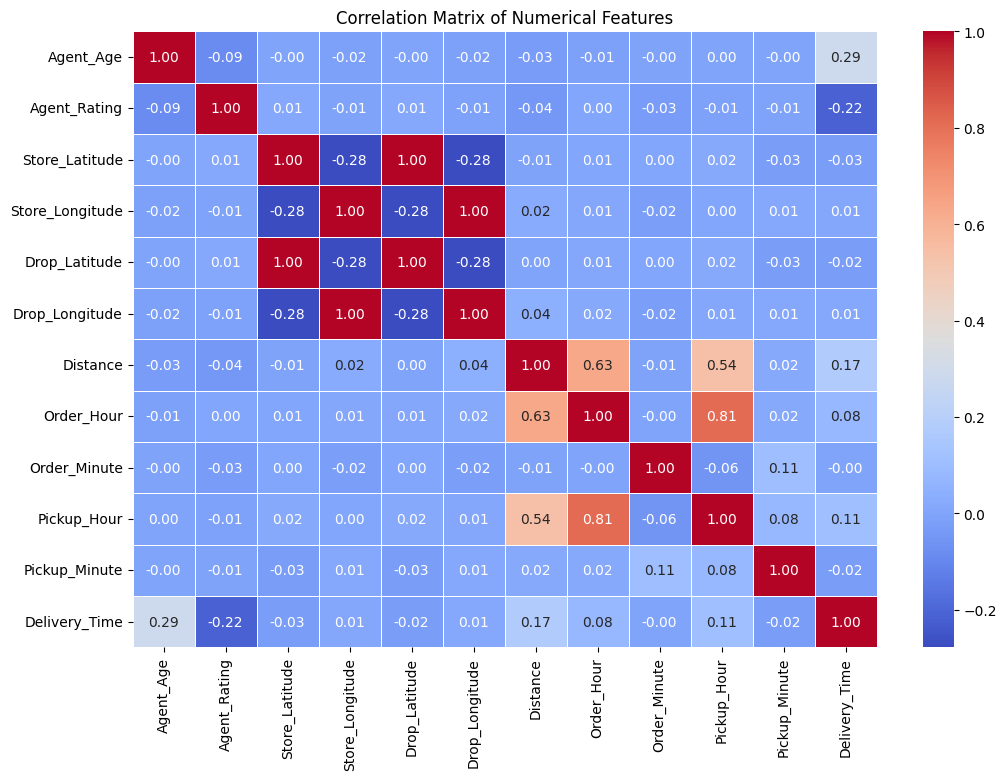

In [61]:
numerical_cols = ['Agent_Age', 'Agent_Rating', 'Store_Latitude', 
                  'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Distance', "Order_Hour","Order_Minute","Pickup_Hour","Pickup_Minute", 'Delivery_Time']
# Assemble numerical columns into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_data = assembler.transform(data).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(vector_data, "features").head()[0].toArray()

# # Convert correlation matrix to Pandas DataFrame for better readability
import pandas as pd
correlation_df = pd.DataFrame(
    correlation_matrix, 
    columns=numerical_cols, 
    index=numerical_cols
)

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [62]:
from pyspark.sql.functions import mean, col, count
from scipy.stats import f

def anova_all(df, categorical_cols, target_col):
    # Overall mean of the target column
    overall_mean = df.select(mean(target_col)).first()[0]
    results = {}
    for categorical_col in categorical_cols:
        # Group statistics by the categorical column
        grouped_stats = df.groupBy(categorical_col).agg(
            mean(target_col).alias('group_mean'),
            count(target_col).alias('group_count')
        )
        # Calculate Between-Group Sum of Squares (SSB)
        ssb = grouped_stats.withColumn(
            'ssb',
            (col('group_mean') - overall_mean) ** 2 * col('group_count')
        ).agg({'ssb': 'sum'}).first()[0]
        # Calculate Within-Group Sum of Squares (SSW)
        ssw = df.join(grouped_stats, on=categorical_col).withColumn(
            'ssw',
            (col(target_col) - col('group_mean')) ** 2
        ).agg({'ssw': 'sum'}).first()[0]
        # Degrees of freedom
        df_between = grouped_stats.count() - 1  # Number of groups - 1
        df_within = df.count() - grouped_stats.count()  # Total samples - number of groups
        # Calculate F-statistic
        ms_between = ssb / df_between if df_between != 0 else 0
        ms_within = ssw / df_within if df_within != 0 else 0
        f_statistic = ms_between / ms_within if ms_within != 0 else 0
        # Calculate p-value using scipy
        p_value = 1 - f.cdf(f_statistic, df_between, df_within) if df_within > 0 else 1
        # Store results
        results[categorical_col] = {
            'F-Statistic': f_statistic,
            'p-value': p_value,
            'df_between': df_between,
            'df_within': df_within
        }
    return results


# List of categorical columns and target column
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
target_col = "Delivery_Time"

# Perform ANOVA
anova_results = anova_all(data, categorical_cols, target_col)

# Display results
print("ANOVA Results:")
for feature, stats in anova_results.items():
    print(f"Feature: {feature}")
    print(f"  F-Statistic: {stats['F-Statistic']:.2f}")
    print(f"  p-value: {stats['p-value']:.14f}")
    print(f"  Degrees of Freedom (Between): {stats['df_between']}")
    print(f"  Degrees of Freedom (Within): {stats['df_within']}")
    print("\n")


25/02/02 17:33:58 WARN TaskSetManager: Stage 161 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:33:59 WARN TaskSetManager: Stage 164 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:34:01 WARN TaskSetManager: Stage 170 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:34:01 WARN TaskSetManager: Stage 171 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:34:03 WARN TaskSetManager: Stage 179 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:34:03 WARN TaskSetManager: Stage 185 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:34:04 WARN TaskSetManager: Stage 188 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.

ANOVA Results:
Feature: Weather
  F-Statistic: 2989.12
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 5
  Degrees of Freedom (Within): 197050


Feature: Traffic
  F-Statistic: 5601.12
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 3
  Degrees of Freedom (Within): 197052


Feature: Vehicle
  F-Statistic: 1509.93
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 2
  Degrees of Freedom (Within): 197053


Feature: Area
  F-Statistic: 3783.60
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 2
  Degrees of Freedom (Within): 197053


Feature: Category
  F-Statistic: 4248.58
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 15
  Degrees of Freedom (Within): 197040




In [63]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Step 1: Define columns
numerical_cols = ['Agent_Age', 'Agent_Rating', 'Distance', 'Pickup_Hour']
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

# Step 2: Index categorical columns (convert strings to numbers)
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Indexed") for col in categorical_cols]

# Step 3: One-hot encode categorical features (transform indexed labels to one-hot encoding)
encoders = [OneHotEncoder(inputCol=f"{col}_Indexed", outputCol=f"{col}_OneHot") for col in categorical_cols]

# Step 4: Assemble numerical and categorical features into a single vector
assembler = VectorAssembler(inputCols=numerical_cols + [f"{col}_OneHot" for col in categorical_cols], outputCol="features")

# Step 5: Apply transformations to the data (indexing, encoding, assembling)
pipeline_steps = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_steps)
data_transformed = pipeline.fit(data).transform(data)

# Step 6: Split the data into training and test sets
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 7: Scale numerical features for Linear Regression (only)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
train_data_scaled = scaler.fit(train_data).transform(train_data)
test_data_scaled = scaler.fit(test_data).transform(test_data)

results=[]

25/02/02 17:37:11 WARN TaskSetManager: Stage 314 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:13 WARN TaskSetManager: Stage 317 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:14 WARN TaskSetManager: Stage 320 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:16 WARN TaskSetManager: Stage 323 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:17 WARN TaskSetManager: Stage 326 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:19 WARN TaskSetManager: Stage 329 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:22 WARN TaskSetManager: Stage 332 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.

In [64]:
# Step 8: Cross-Validation setup for Linear Regression with scaled features
lr = LinearRegression(featuresCol="scaled_features", labelCol="Delivery_Time")

# Define hyperparameter grid for Linear Regression
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


# Setup evaluator and cross-validation
evaluator = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="rmse")
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5)

# Fit Linear Regression with Cross-Validation
cv_model_lr = cv_lr.fit(train_data_scaled)

# Best model for Linear Regression
best_model_lr = cv_model_lr.bestModel

# Step 9: Predict and evaluate on test data for Linear Regression
predictions_lr = best_model_lr.transform(test_data_scaled)
rmse_lr = evaluator.evaluate(predictions_lr)
mae_lr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_lr)
r2_lr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_lr)

print("Linear Regression Performance (CV):")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")
print(f"R²: {r2_lr:.3f}")
results.append(("Linear Regression", rmse_lr, mae_lr, r2_lr))

25/02/02 17:37:34 WARN TaskSetManager: Stage 335 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:37 WARN TaskSetManager: Stage 336 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/02/02 17:37:38 WARN TaskSetManager: Stage 338 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:39 WARN TaskSetManager: Stage 340 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:41 WARN TaskSetManager: Stage 341 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:42 WARN TaskSetManager: Stage 343 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:37:42 WARN TaskSetM

Linear Regression Performance (CV):
RMSE: 29.819
MAE: 23.703
R²: 0.560


In [65]:
# Print the best model's hyperparameters
print("Best Model Hyperparameters:")
print(best_model_lr.extractParamMap())

Best Model Hyperparameters:
{Param(parent='LinearRegression_91e5f6639837', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_91e5f6639837', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_91e5f6639837', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35, Param(parent='LinearRegression_91e5f6639837', name='featuresCol', doc='features column name.'): 'scaled_features', Param(parent='LinearRegression_91e5f6639837', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_91e5f6639837', name='labelCol', doc='label column name.'): 'Delivery_Time', Param(parent='LinearRegression_91e5f6639837', name='loss', doc='The loss function to be optimized. Supported options: 

In [66]:
from pyspark.ml.regression import GBTRegressor

# Step 10: Cross-Validation setup for Gradient-Boosted Trees (GBT)
gbt = GBTRegressor(featuresCol="features", labelCol="Delivery_Time", maxIter=100, seed=42, validationTol=0.01)

param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .addGrid(gbt.stepSize, [0.01, 0.1, 0.3]) \
    .build()


# Setup cross-validation for GBT
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=5)

# Fit GBT with Cross-Validation
cv_model_gbt = cv_gbt.fit(train_data)

# Best model for GBT
best_model_gbt = cv_model_gbt.bestModel

# Step 11: Predict and evaluate on test data for GBT
predictions_gbt = best_model_gbt.transform(test_data)
rmse_gbt = evaluator.evaluate(predictions_gbt)
mae_gbt = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_gbt)
r2_gbt = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_gbt)

print("GBT Performance (CV):")
print(f"RMSE: {rmse_gbt:.3f}")
print(f"MAE: {mae_gbt:.3f}")
print(f"R²: {r2_gbt:.3f}")
results.append(("GBT", rmse_gbt, mae_gbt, r2_gbt))
# Print the best model's hyperparameters
print("Best Model Hyperparameters for GBT:")
print(best_model_gbt.extractParamMap())

# Optionally, print the GBT specific parameters like trees' information
print(f"Best Model MaxDepth: {best_model_gbt.getMaxDepth()}")
print(f"Best Model MaxIter: {best_model_gbt.getMaxIter()}")
print(f"Best Model StepSize: {best_model_gbt.getStepSize()}")

25/02/02 17:39:26 WARN TaskSetManager: Stage 625 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:39:29 WARN TaskSetManager: Stage 626 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:39:29 WARN TaskSetManager: Stage 627 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:39:29 WARN TaskSetManager: Stage 628 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:39:30 WARN TaskSetManager: Stage 630 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:39:31 WARN TaskSetManager: Stage 632 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 17:39:31 WARN TaskSetManager: Stage 634 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.

GBT Performance (CV):
RMSE: 11.613
MAE: 6.729
R²: 0.933
Best Model Hyperparameters for GBT:
{Param(parent='GBTRegressor_8f9967c7da4f', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_8f9967c7da4f', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_8f9967c7da4f', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'a

In [67]:
from pyspark.ml.regression import DecisionTreeRegressor

# Step 10: Cross-Validation setup for Decision Tree Regressor (DTR)
dtr = DecisionTreeRegressor(featuresCol="features", labelCol="Delivery_Time")

# Define hyperparameter grid for DTR
param_grid_dtr = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [5, 10, 20]) \
    .addGrid(dtr.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Setup cross-validation for DTR
cv_dtr = CrossValidator(estimator=dtr, estimatorParamMaps=param_grid_dtr, evaluator=evaluator, numFolds=5)

# Fit DTR with Cross-Validation
cv_model_dtr = cv_dtr.fit(train_data)

# Best model for DTR
best_model_dtr = cv_model_dtr.bestModel

# Step 11: Predict and evaluate on test data for DTR
predictions_dtr = best_model_dtr.transform(test_data)
rmse_dtr = evaluator.evaluate(predictions_dtr)
mae_dtr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_dtr)
r2_dtr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_dtr)

print("Decision Tree Regressor Performance (CV):")
print(f"RMSE: {rmse_dtr:.3f}")
print(f"MAE: {mae_dtr:.3f}")
print(f"R²: {r2_dtr:.3f}")
results.append(("Decision Tree", rmse_dtr, mae_dtr, r2_dtr))

# Print the best model's hyperparameters
print("Best Model Hyperparameters for DTR:")
print(best_model_dtr.extractParamMap())

# Optionally, print DTR specific parameters like maxDepth and minInstancesPerNode
print(f"Best Model MaxDepth: {best_model_dtr.getMaxDepth()}")
print(f"Best Model MinInstancesPerNode: {best_model_dtr.getMinInstancesPerNode()}")

25/02/02 19:32:14 WARN TaskSetManager: Stage 74855 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:32:17 WARN TaskSetManager: Stage 74856 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:32:17 WARN TaskSetManager: Stage 74857 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:32:17 WARN TaskSetManager: Stage 74858 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:32:18 WARN TaskSetManager: Stage 74860 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:32:20 WARN TaskSetManager: Stage 74862 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:32:20 WARN TaskSetManager: Stage 74864 contains a task of very large size (3603 KiB). The maximum recommended task siz

Decision Tree Regressor Performance (CV):
RMSE: 11.230
MAE: 4.488
R²: 0.938
Best Model Hyperparameters for DTR:
{Param(parent='DecisionTreeRegressor_581cac8c9fd2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_581cac8c9fd2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_581cac8c9fd2', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeRegressor_581cac8c9fd2', name='impurity', doc='Cri

In [68]:
# Step 10: Cross-Validation setup for Random Forest (without scaling)
rf = RandomForestRegressor(featuresCol="features", labelCol="Delivery_Time")

# Define hyperparameter grid for Random Forest (you can add more parameters to tune)
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()


# Setup cross-validation for Random Forest
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)

# Fit Random Forest with Cross-Validation
cv_model_rf = cv_rf.fit(train_data)

# Best model for Random Forest
best_model_rf = cv_model_rf.bestModel

# Step 11: Predict and evaluate on test data for Random Forest
predictions_rf = best_model_rf.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
mae_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_rf)
r2_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_rf)

print("Random Forest Performance (CV):")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")
print(f"R²: {r2_rf:.3f}")
results.append(("Random Forest", rmse_rf, mae_rf, r2_rf))

# Get the best model from cross-validation
best_model_rf = cv_model_rf.bestModel

# Print the best model's hyperparameters
print("Best Model Hyperparameters for Random Forest:")
print(best_model_rf.extractParamMap())

25/02/02 19:35:01 WARN TaskSetManager: Stage 76235 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:35:02 WARN TaskSetManager: Stage 76236 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:35:02 WARN TaskSetManager: Stage 76237 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:35:02 WARN TaskSetManager: Stage 76238 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:35:03 WARN TaskSetManager: Stage 76240 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:35:04 WARN TaskSetManager: Stage 76242 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 19:35:04 WARN TaskSetManager: Stage 76244 contains a task of very large size (3603 KiB). The maximum recommended task siz

Random Forest Performance (CV):
RMSE: 9.098
MAE: 4.741
R²: 0.959
Best Model Hyperparameters for Random Forest:
{Param(parent='RandomForestRegressor_57dc8ff319f3', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestRegressor_57dc8ff319f3', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestRegressor_57dc8ff319f3', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestRegressor_57dc8ff319f3', 

In [69]:
print("Comparison of Models:")
print(f"{'Model':<25} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
for name, rmse, mae, r2 in results:
    print(f"{name:<25} {rmse:<10.3f} {mae:<10.3f} {r2:<10.3f}")


Comparison of Models:
Model                     RMSE       MAE        R²        
Linear Regression         29.819     23.703     0.560     
GBT                       11.613     6.729      0.933     
Decision Tree             11.230     4.488      0.938     
Random Forest             9.098      4.741      0.959     


In [70]:
# Step 12: Evaluate Random Forest on Training Data
train_predictions_rf = best_model_rf.transform(train_data)
rmse_train_rf = evaluator.evaluate(train_predictions_rf)
mae_train_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(train_predictions_rf)
r2_train_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(train_predictions_rf)

print("Random Forest Performance (Training):")
print(f"Training RMSE: {rmse_train_rf:.3f}")
print(f"Training MAE: {mae_train_rf:.3f}")
print(f"Training R²: {r2_train_rf:.3f}")

# Compare Train vs Test Performance
print("Random Forest Train vs Test Comparison:")
print(f"Train RMSE: {rmse_train_rf:.3f}, Test RMSE: {rmse_rf:.3f}")
print(f"Train MAE: {mae_train_rf:.3f}, Test MAE: {mae_rf:.3f}")
print(f"Train R²: {r2_train_rf:.3f}, Test R²: {r2_rf:.3f}")

if rmse_train_rf < rmse_rf * 0.5:
    print("The model might be overfitting.")
elif abs(rmse_train_rf - rmse_rf) < (0.1 * rmse_train_rf):
    print("The model generalizes well.")
else:
    print("The model may need further tuning.")


25/02/02 20:47:46 WARN TaskSetManager: Stage 77615 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:47:52 WARN TaskSetManager: Stage 77617 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:47:56 WARN TaskSetManager: Stage 77619 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Random Forest Performance (Training):
Training RMSE: 7.124
Training MAE: 3.874
Training R²: 0.975
Random Forest Train vs Test Comparison:
Train RMSE: 7.124, Test RMSE: 9.098
Train MAE: 3.874, Test MAE: 4.741
Train R²: 0.975, Test R²: 0.959
The model may need further tuning.


Analyzing residuals for Linear Regression...
Descriptive Statistics of Residuals (Linear Regression):


25/02/02 20:48:08 WARN TaskSetManager: Stage 77621 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+
|summary|          Residuals|
+-------+-------------------+
|  count|              39174|
|   mean|0.21133831549147183|
| stddev| 29.818401489381287|
|    min| -99.28267739433844|
|    max| 125.40700549309027|
+-------+-------------------+



25/02/02 20:48:10 WARN TaskSetManager: Stage 77624 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 800x600 with 0 Axes>

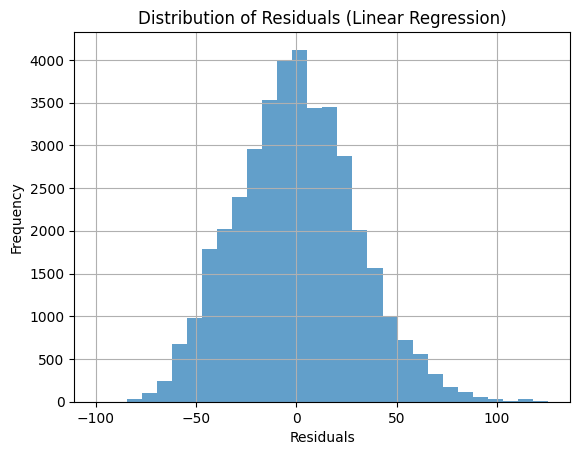

Analyzing residuals for GBT...
Descriptive Statistics of Residuals (GBT):


25/02/02 20:48:14 WARN TaskSetManager: Stage 77625 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+
|summary|           Residuals|
+-------+--------------------+
|  count|               39174|
|   mean|-0.10713048046348375|
| stddev|  11.612443417848086|
|    min|  -88.90783159644607|
|    max|  128.53694785583303|
+-------+--------------------+



25/02/02 20:48:17 WARN TaskSetManager: Stage 77628 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 800x600 with 0 Axes>

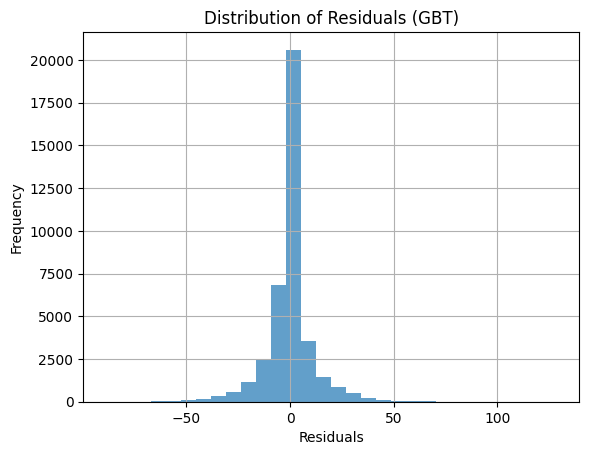

Analyzing residuals for Decision Tree...
Descriptive Statistics of Residuals (Decision Tree):


25/02/02 20:48:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/02/02 20:48:22 WARN TaskSetManager: Stage 77629 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+
|summary|           Residuals|
+-------+--------------------+
|  count|               39174|
|   mean|-0.06312568839789569|
| stddev|   11.22952770128008|
|    min|              -140.0|
|    max|               145.0|
+-------+--------------------+



25/02/02 20:48:24 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/02/02 20:48:24 WARN TaskSetManager: Stage 77632 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 800x600 with 0 Axes>

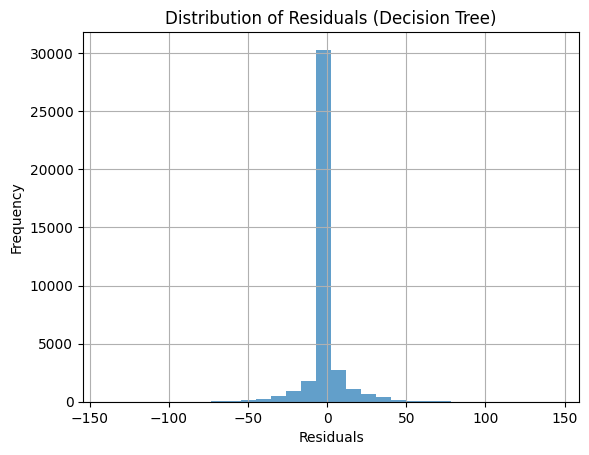

Analyzing residuals for Random Forest...
Descriptive Statistics of Residuals (Random Forest):


25/02/02 20:48:38 WARN TaskSetManager: Stage 77633 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+
|summary|          Residuals|
+-------+-------------------+
|  count|              39174|
|   mean|-0.0538303703348717|
| stddev|  9.097880629814517|
|    min|  -70.8217194745086|
|    max| 118.43628119005261|
+-------+-------------------+



25/02/02 20:48:43 WARN TaskSetManager: Stage 77636 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


<Figure size 800x600 with 0 Axes>

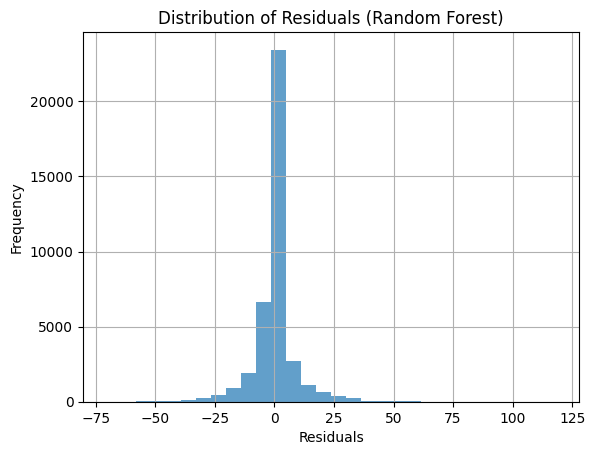

In [71]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Function to calculate and analyze residuals for a model
def analyze_residuals(model_name, predictions, labelCol="Delivery_Time"):
    # Calculate residuals
    residuals = predictions.withColumn("Residuals", col(labelCol) - col("prediction"))
    
    # Descriptive statistics
    print(f"Descriptive Statistics of Residuals ({model_name}):")
    residuals.select("Residuals").describe().show()
    
    # Convert residuals to Pandas for plotting
    residuals_pd = residuals.select("Residuals").toPandas()
    
    # Plot residuals distribution
    plt.figure(figsize=(8, 6))
    residuals_pd.plot(kind="hist", bins=30, title=f"Distribution of Residuals ({model_name})", alpha=0.7, legend=False)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


# Analyze residuals for all models
models = [
    ("Linear Regression", best_model_lr, test_data_scaled),
    ("GBT", best_model_gbt, test_data),
    ("Decision Tree", best_model_dtr, test_data),
    ("Random Forest", best_model_rf, test_data),
]

for model_name, model, data in models:
    print(f"Analyzing residuals for {model_name}...")
    predictions = model.transform(data)
    analyze_residuals(model_name, predictions)


In [72]:
# Function to save residuals to a CSV file
def save_residuals_to_csv(model_name, predictions, labelCol="Delivery_Time", file_path="residuals_{}.csv"):
    # Calculate residuals
    residuals = predictions.withColumn("Residuals", col(labelCol) - col("prediction"))
    
    # Save residuals to a CSV file
    file_name = file_path.format(model_name.replace(" ", "_").lower())
    residuals.select(labelCol, "prediction", "Residuals").write.csv(file_name, header=True, mode="overwrite")
    print(f"Residuals for {model_name} saved to {file_name}")


# Save residuals for all models
models = [
    ("Linear Regression", best_model_lr, test_data_scaled),
    ("GBT", best_model_gbt, test_data),
    ("Decision Tree", best_model_dtr, test_data),
    ("Random Forest", best_model_rf, test_data),
]

for model_name, model, data in models:
    print(f"Saving residuals for {model_name}...")
    predictions = model.transform(data)
    save_residuals_to_csv(model_name, predictions)


Saving residuals for Linear Regression...


25/02/02 20:49:07 WARN TaskSetManager: Stage 77637 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Residuals for Linear Regression saved to residuals_linear_regression.csv
Saving residuals for GBT...


25/02/02 20:49:11 WARN TaskSetManager: Stage 77638 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Residuals for GBT saved to residuals_gbt.csv
Saving residuals for Decision Tree...


25/02/02 20:49:14 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/02/02 20:49:14 WARN TaskSetManager: Stage 77639 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Residuals for Decision Tree saved to residuals_decision_tree.csv
Saving residuals for Random Forest...


25/02/02 20:49:28 WARN TaskSetManager: Stage 77640 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Residuals for Random Forest saved to residuals_random_forest.csv


In [73]:
# Function to save Actual vs Predicted data to CSV
def save_actual_vs_predicted_to_csv(model_name, predictions, labelCol="Delivery_Time", file_path="actual_vs_predicted_{}.csv"):
    # Select actual and predicted values
    actual_vs_predicted = predictions.select(labelCol, "prediction")
    
    # Save to CSV
    file_name = file_path.format(model_name.replace(" ", "_").lower())
    actual_vs_predicted.write.csv(file_name, header=True, mode="overwrite")
    print(f"Actual vs Predicted data for {model_name} saved to {file_name}")


# Save Actual vs Predicted data for all models
models = [
    ("Linear Regression", best_model_lr, test_data_scaled),
    ("GBT", best_model_gbt, test_data),
    ("Decision Tree", best_model_dtr, test_data),
    ("Random Forest", best_model_rf, test_data),
]

for model_name, model, data in models:
    print(f"Saving Actual vs Predicted data for {model_name}...")
    predictions = model.transform(data)
    save_actual_vs_predicted_to_csv(model_name, predictions)


Saving Actual vs Predicted data for Linear Regression...


25/02/02 20:50:03 WARN TaskSetManager: Stage 77641 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for Linear Regression saved to actual_vs_predicted_linear_regression.csv
Saving Actual vs Predicted data for GBT...


25/02/02 20:50:07 WARN TaskSetManager: Stage 77642 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for GBT saved to actual_vs_predicted_gbt.csv
Saving Actual vs Predicted data for Decision Tree...


25/02/02 20:50:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/02/02 20:50:10 WARN TaskSetManager: Stage 77643 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for Decision Tree saved to actual_vs_predicted_decision_tree.csv
Saving Actual vs Predicted data for Random Forest...


25/02/02 20:50:24 WARN TaskSetManager: Stage 77644 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


Actual vs Predicted data for Random Forest saved to actual_vs_predicted_random_forest.csv


Plotting Actual vs Predicted for Linear Regression...


25/02/02 20:50:27 WARN TaskSetManager: Stage 77645 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


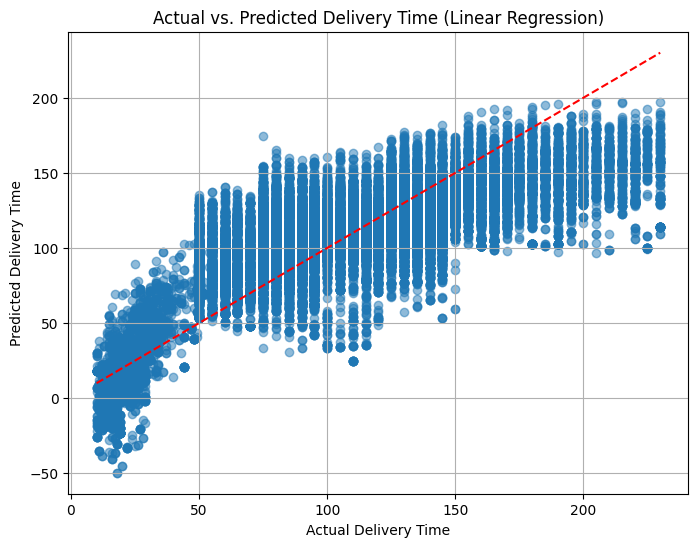

Plotting Actual vs Predicted for GBT...


25/02/02 20:50:30 WARN TaskSetManager: Stage 77646 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


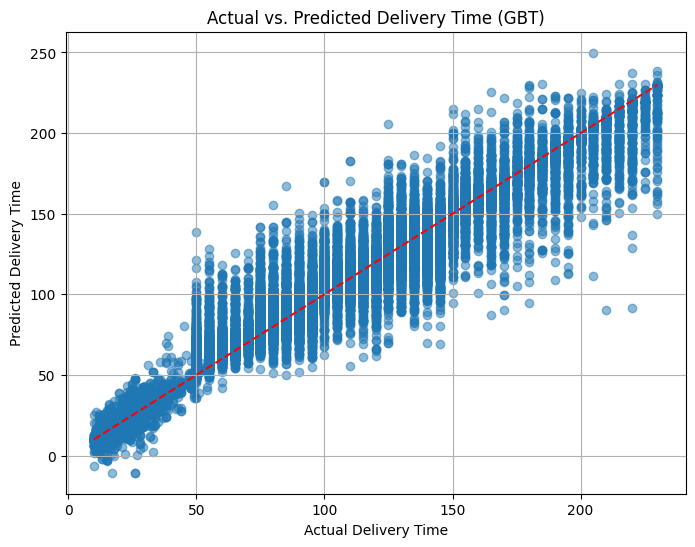

Plotting Actual vs Predicted for Decision Tree...


25/02/02 20:50:33 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/02/02 20:50:33 WARN TaskSetManager: Stage 77647 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


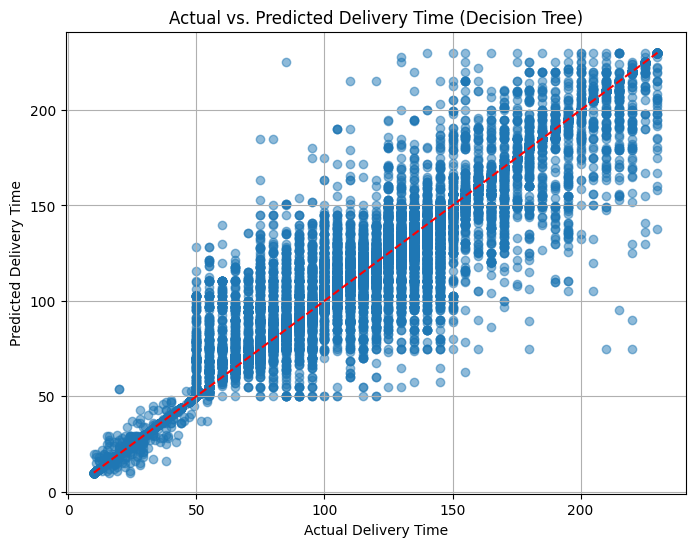

Plotting Actual vs Predicted for Random Forest...


25/02/02 20:50:46 WARN TaskSetManager: Stage 77648 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.


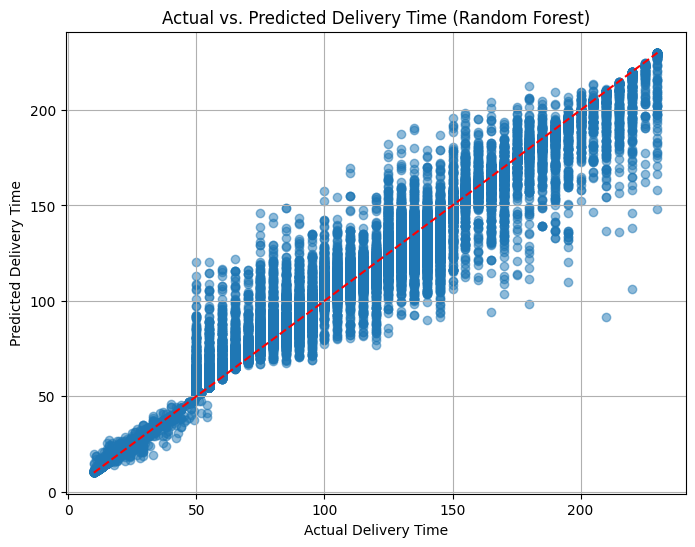

In [74]:
# Function to plot Actual vs Predicted
def plot_actual_vs_predicted(model_name, predictions, labelCol="Delivery_Time"):
    # Convert to Pandas for plotting
    predictions_pd = predictions.select(labelCol, "prediction").toPandas()
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(predictions_pd[labelCol], predictions_pd["prediction"], alpha=0.5)
    plt.plot([min(predictions_pd[labelCol]), max(predictions_pd[labelCol])], 
             [min(predictions_pd[labelCol]), max(predictions_pd[labelCol])], 
             color='red', linestyle='--')  # Line y=x
    plt.xlabel("Actual Delivery Time")
    plt.ylabel("Predicted Delivery Time")
    plt.title(f"Actual vs. Predicted Delivery Time ({model_name})")
    plt.grid()
    plt.show()


# Plot Actual vs Predicted for all models
for model_name, model, data in models:
    print(f"Plotting Actual vs Predicted for {model_name}...")
    predictions = model.transform(data)
    plot_actual_vs_predicted(model_name, predictions)


Calculating learning curve for Linear Regression...


25/02/02 20:50:50 WARN TaskSetManager: Stage 77649 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:50:53 WARN TaskSetManager: Stage 77651 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:50:56 WARN TaskSetManager: Stage 77653 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:50:58 WARN TaskSetManager: Stage 77655 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:01 WARN TaskSetManager: Stage 77657 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:03 WARN TaskSetManager: Stage 77659 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:06 WARN TaskSetManager: Stage 77661 contains a task of very large size (3603 KiB). The maximum recommended task siz

Learning curve data for Linear Regression saved to learning_curve_linear_regression.csv


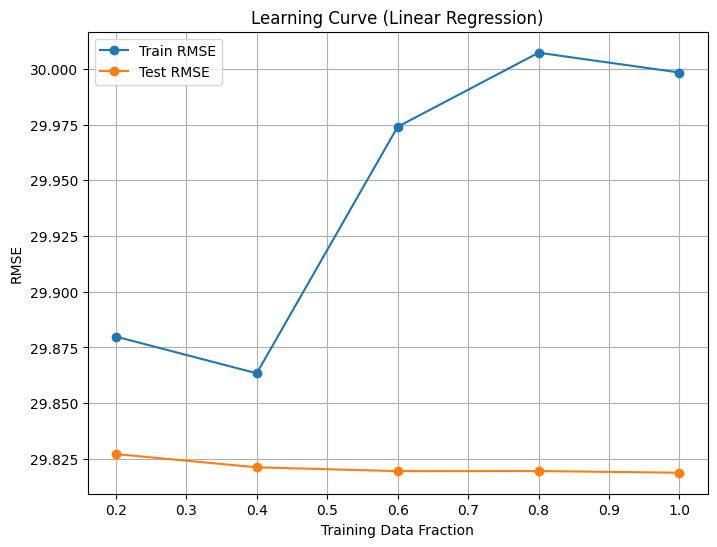

Calculating learning curve for GBT...


25/02/02 20:51:40 WARN TaskSetManager: Stage 77689 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:41 WARN TaskSetManager: Stage 77690 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:42 WARN TaskSetManager: Stage 77691 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:45 WARN TaskSetManager: Stage 77693 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:47 WARN TaskSetManager: Stage 77695 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:47 WARN TaskSetManager: Stage 77697 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 20:51:47 WARN TaskSetManager: Stage 77699 contains a task of very large size (3603 KiB). The maximum recommended task siz

Learning curve data for GBT saved to learning_curve_gbt.csv


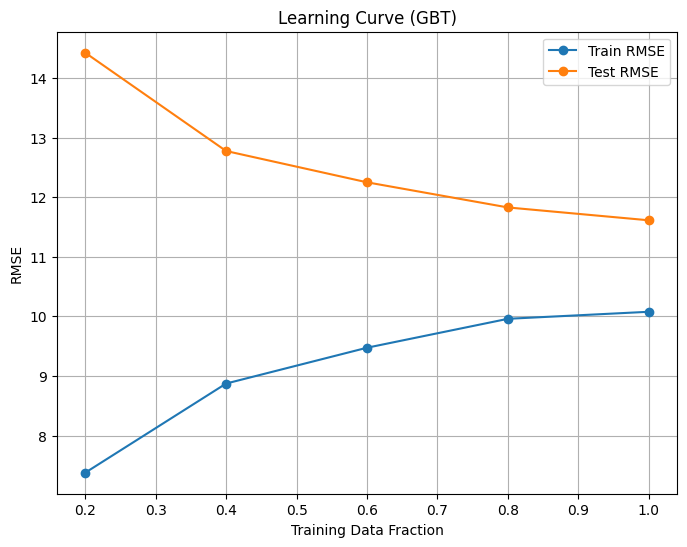

Calculating learning curve for Decision Tree...


25/02/02 21:06:38 WARN TaskSetManager: Stage 84729 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:06:39 WARN TaskSetManager: Stage 84730 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:06:40 WARN TaskSetManager: Stage 84731 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:06:42 WARN TaskSetManager: Stage 84733 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:06:44 WARN TaskSetManager: Stage 84735 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:06:44 WARN TaskSetManager: Stage 84737 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:06:44 WARN TaskSetManager: Stage 84739 contains a task of very large size (3603 KiB). The maximum recommended task siz

Learning curve data for Decision Tree saved to learning_curve_decision_tree.csv


25/02/02 21:08:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


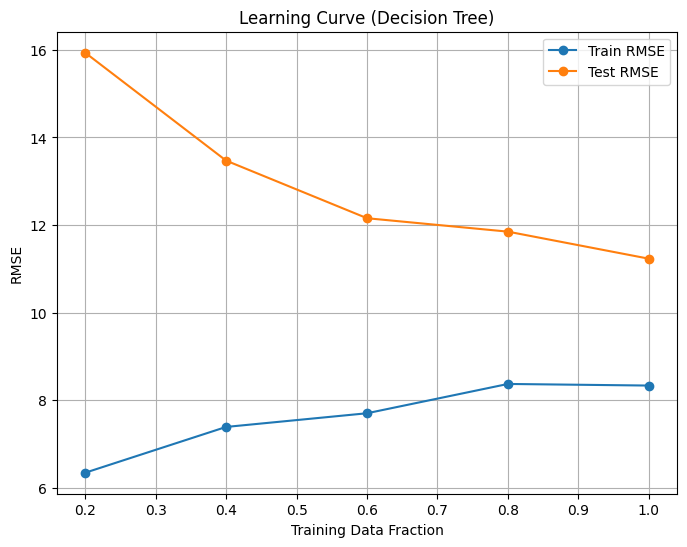

Calculating learning curve for Random Forest...


25/02/02 21:08:11 WARN TaskSetManager: Stage 84969 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:08:12 WARN TaskSetManager: Stage 84970 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:08:13 WARN TaskSetManager: Stage 84971 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:08:15 WARN TaskSetManager: Stage 84973 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:08:17 WARN TaskSetManager: Stage 84975 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:08:18 WARN TaskSetManager: Stage 84977 contains a task of very large size (3603 KiB). The maximum recommended task size is 1000 KiB.
25/02/02 21:08:18 WARN TaskSetManager: Stage 84979 contains a task of very large size (3603 KiB). The maximum recommended task siz

Learning curve data for Random Forest saved to learning_curve_random_forest.csv


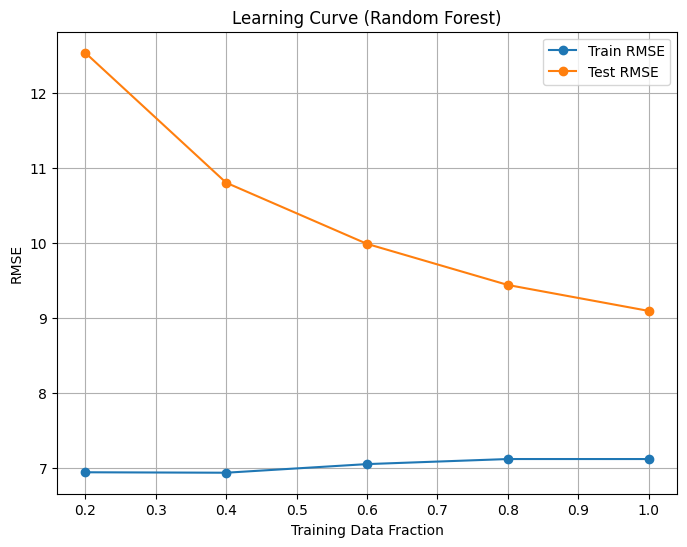

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression

# Function to calculate and save learning curve data
def save_learning_curve_to_csv(model_name, model, train_data, test_data, labelCol="Delivery_Time", file_path="learning_curve_{}.csv"):
    evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="rmse")
    
    # Fraction of training data used for learning curve
    fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
    train_rmse = []
    test_rmse = []
    
    for frac in fractions:
        # Sample training data
        sampled_train_data = train_data.sample(withReplacement=False, fraction=frac, seed=42)
        
        # Fit the model
        fitted_model = model.fit(sampled_train_data)
        
        # Evaluate RMSE on train and test data
        train_rmse.append(evaluator.evaluate(fitted_model.transform(sampled_train_data)))
        test_rmse.append(evaluator.evaluate(fitted_model.transform(test_data)))
    
    # Save learning curve data to CSV
    learning_curve_data = list(zip(fractions, train_rmse, test_rmse))
    file_name = file_path.format(model_name.replace(" ", "_").lower())
    pd.DataFrame(learning_curve_data, columns=["Fraction", "Train_RMSE", "Test_RMSE"]).to_csv(file_name, index=False)
    print(f"Learning curve data for {model_name} saved to {file_name}")
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(fractions, train_rmse, label="Train RMSE", marker="o")
    plt.plot(fractions, test_rmse, label="Test RMSE", marker="o")
    plt.xlabel("Training Data Fraction")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve ({model_name})")
    plt.legend()
    plt.grid()
    plt.show()

# Define models with best parameters
models = [
    ("Linear Regression", LinearRegression(featuresCol="scaled_features", labelCol="Delivery_Time", maxIter=100, regParam=0.01, solver="auto"), train_data_scaled, test_data_scaled),
    ("GBT", GBTRegressor(featuresCol="features", labelCol="Delivery_Time", maxIter=100, stepSize=0.3, maxDepth=7, seed=42), train_data, test_data),
    ("Decision Tree", DecisionTreeRegressor(featuresCol="features", labelCol="Delivery_Time", maxDepth=20), train_data, test_data),
    ("Random Forest", RandomForestRegressor(featuresCol="features", labelCol="Delivery_Time", maxDepth=20, numTrees=100), train_data, test_data),
]

# Iterate over models and calculate learning curves
for model_name, model, train_data, test_data in models:
    print(f"Calculating learning curve for {model_name}...")
    save_learning_curve_to_csv(model_name, model, train_data, test_data)
